<a href="https://colab.research.google.com/github/eunhabaek/Dacon/blob/main/%EC%A0%9C1%ED%9A%8C_%EC%8B%A0%EC%95%BD%EA%B0%9C%EB%B0%9C_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 제1회 신약개발 AI 경진대회

## 1. 데이터 가져오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#warning 제거
import warnings
warnings.filterwarnings('ignore')

#데이터 가져오기
train=pd.read_csv('./train.csv',index_col='id')
test=pd.read_csv('./test.csv',index_col='id')
submission=pd.read_csv('./sample_submission.csv',index_col='id')

## 2. 데이터 탐색

### 데이터 탐색 위한 정보 요약 함수

In [2]:
#데이터 정보 요약 함수 만들기
def summaryTable(df):
    print('데이터 구조: ',df.shape)
    summary=pd.DataFrame(df.dtypes,columns=['데이터 타입'])
    summary=summary.reset_index()
    summary=summary.rename(columns={'index':'피쳐'})
    summary['NAN 개수']=df.isnull().sum().values
    summary['데이터 종류']=df.nunique().values
    return summary

### 훈련 데이터 확인

In [3]:
#train data 정보 요약
summaryTable(train)

데이터 구조:  (3498, 10)


,피쳐,데이터 타입,NAN 개수,데이터 종류
0,SMILES,object,0,3471
1,MLM,float64,0,2735
2,HLM,float64,0,2781
3,AlogP,float64,2,2561
4,Molecular_Weight,float64,0,3052
5,Num_H_Acceptors,int64,0,15
6,Num_H_Donors,int64,0,10
7,Num_RotatableBonds,int64,0,20
8,LogD,float64,0,2635
9,Molecular_PolarSurfaceArea,float64,0,2164


### 테스트 데이터 확인

In [4]:
## test data 정보 요약
summaryTable(test)

데이터 구조:  (483, 8)


,피쳐,데이터 타입,NAN 개수,데이터 종류
0,SMILES,object,0,483
1,AlogP,float64,1,465
2,Molecular_Weight,float64,0,469
3,Num_H_Acceptors,int64,0,12
4,Num_H_Donors,int64,0,6
5,Num_RotatableBonds,int64,0,14
6,LogD,float64,0,466
7,Molecular_PolarSurfaceArea,float64,0,430


##3. 전처리

### 타겟 피쳐 분리

In [5]:
#target 열 추출
target=['MLM','HLM']
y=train[target]

train=train.drop(target,axis=1)

### 문자열 피쳐 SMILES 제외

In [6]:
train.drop('SMILES',axis=1,inplace=True)
test.drop('SMILES',axis=1,inplace=True)

### 결측치 처리

In [7]:
import statistics as st

train['AlogP'].fillna(st.median(train.AlogP),inplace=True)

test['AlogP'].fillna(st.median(test.AlogP),inplace=True)
#뒤에서 SimpleImputer 이용하므로 지워도 됨

### 이상치 처리

In [8]:
#수치 단위가 100이 넘을 수 없으므로 100 넘는 이상치 100으로 처리

y.MLM[(y.MLM >=100)]=100
y.HLM[(y.HLM >=100)]=100

##4. 피쳐간 상관성 확인

In [9]:
test.corr()

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
AlogP,1.000000,0.383311,-0.313087,-0.153354,0.035197,0.955978,-0.313012
Molecular_Weight,0.383311,1.000000,0.484941,0.028149,0.525084,0.353819,0.407040
Num_H_Acceptors,-0.313087,0.484941,1.000000,0.082886,0.480579,-0.333962,0.721240
Num_H_Donors,-0.153354,0.028149,0.082886,1.000000,0.199530,-0.178043,0.415184
Num_RotatableBonds,0.035197,0.525084,0.480579,0.199530,1.000000,-0.008562,0.371430
LogD,0.955978,0.353819,-0.333962,-0.178043,-0.008562,1.000000,-0.305764
Molecular_PolarSurfaceArea,-0.313012,0.407040,0.721240,0.415184,0.371430,-0.305764,1.000000


In [10]:
train.corr()

,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,Molecular_PolarSurfaceArea
AlogP,1.000000,0.389675,-0.284376,-0.172130,0.111767,0.957050,-0.297994
Molecular_Weight,0.389675,1.000000,0.471814,0.116186,0.583711,0.369462,0.439114
Num_H_Acceptors,-0.284376,0.471814,1.000000,0.208433,0.474012,-0.305506,0.714315
Num_H_Donors,-0.172130,0.116186,0.208433,1.000000,0.176871,-0.212082,0.474614
Num_RotatableBonds,0.111767,0.583711,0.474012,0.176871,1.000000,0.071659,0.371574
LogD,0.957050,0.369462,-0.305506,-0.212082,0.071659,1.000000,-0.294670
Molecular_PolarSurfaceArea,-0.297994,0.439114,0.714315,0.474614,0.371574,-0.294670,1.000000


##5. 다중 공선성 확인

In [11]:
#VIF 값 확인
from statsmodels.stats.outliers_influence import variance_inflation_factor

#VIF 값 확인 함수
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF_print(data):
    vif = pd.DataFrame()
    vif["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    vif["features"] = data.columns
    print(vif.round(1),end='\n\n')

VIF_print(train)
VIF_print(test)

    VIF                    features
0  53.3                       AlogP
1  43.6            Molecular_Weight
2  22.2             Num_H_Acceptors
3   3.2                Num_H_Donors
4   7.6          Num_RotatableBonds
5  45.9                        LogD
6  25.7  Molecular_PolarSurfaceArea

    VIF                    features
0  44.8                       AlogP
1  40.7            Molecular_Weight
2  23.3             Num_H_Acceptors
3   3.3                Num_H_Donors
4   7.4          Num_RotatableBonds
5  35.9                        LogD
6  27.7  Molecular_PolarSurfaceArea



## 6. 다중 공선성 제거

### 6-1. Feature selection (VIF <=10 되도록 )

다중 공선성 제거 결과 확인을 위한 단계이며 실제 Feature selection은 그리드서치 단계에서 진행

In [12]:
# VIF 값 높은 피쳐부터 제외 후 다시 VIF 확인
# 모든 피쳐 VIF <= 10로 만들기

drop_col=['AlogP','Molecular_Weight','Molecular_PolarSurfaceArea']#Molecular_PolarSurfaceArea','Molecular_Weight','AlogP'

sub_train=train.drop(drop_col,axis=1,inplace=False)
sub_test=test.drop(drop_col,axis=1,inplace=False)

VIF_print(sub_train)
VIF_print(sub_test)

   VIF            features
0  6.5     Num_H_Acceptors
1  2.3        Num_H_Donors
2  6.7  Num_RotatableBonds
3  2.5                LogD

   VIF            features
0  5.8     Num_H_Acceptors
1  2.1        Num_H_Donors
2  6.6  Num_RotatableBonds
3  2.1                LogD



### 상관성 제거 확인

In [13]:
sub_train.corr()

,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD
Num_H_Acceptors,1.000000,0.208433,0.474012,-0.305506
Num_H_Donors,0.208433,1.000000,0.176871,-0.212082
Num_RotatableBonds,0.474012,0.176871,1.000000,0.071659
LogD,-0.305506,-0.212082,0.071659,1.000000


In [14]:
sub_test.corr()

,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD
Num_H_Acceptors,1.000000,0.082886,0.480579,-0.333962
Num_H_Donors,0.082886,1.000000,0.199530,-0.178043
Num_RotatableBonds,0.480579,0.199530,1.000000,-0.008562
LogD,-0.333962,-0.178043,-0.008562,1.000000


## 6-2.PCA 차원 축소 (차원축소 대신 feature selection 이용)

In [15]:
#from sklearn.decomposition import PCA
#pca = PCA(n_components=3) # 주성분을 몇개로 할지 결정
#printcipalComponents = pca.fit_transform(test)
#sum(pca.explained_variance_ratio_)

#principalDf = pd.DataFrame(data=printcipalComponents, columns = ['pc1', 'pc2','pc3'])
# 주성분으로 이루어진 데이터 프레임 구성

#print(principalDf)

#all_data=principalDf

##7. 스케일러 선택

### 스케일링 결과 확인 함수

In [16]:
##  결과 시각화 함수 만들기
def Scaled_print(scaler,data):
  Scaler=scaler
  sc_data = pd.DataFrame(Scaler.fit_transform(data),columns=data.columns)

  print(Scaler.__class__.__name__+"로 스케일링 전 후 분포 확인")
  #분포 확인하기
  data.hist()
  sc_data.hist()


### 스케일링 전 후 결과 확인

RobustScaler로 스케일링 전 후 분포 확인


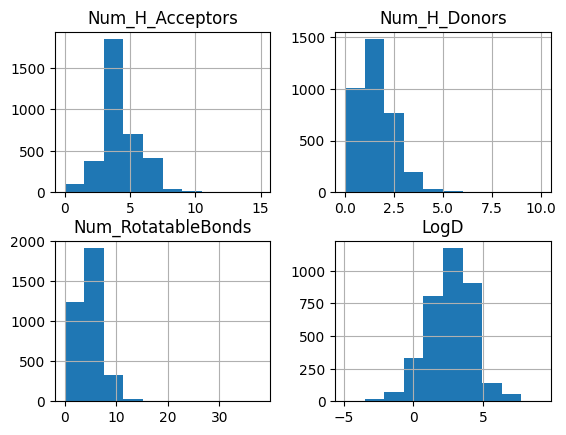

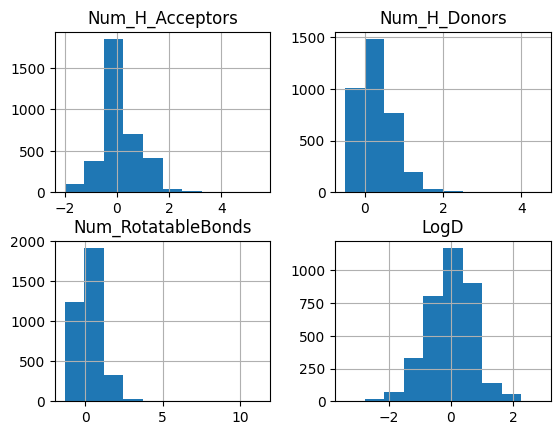

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

##train data

#Scaled_print(StandardScaler(),sub_train)
Scaled_print(RobustScaler(),sub_train)
#Scaled_print(MinMaxScaler(),sub_train)


RobustScaler로 스케일링 전 후 분포 확인


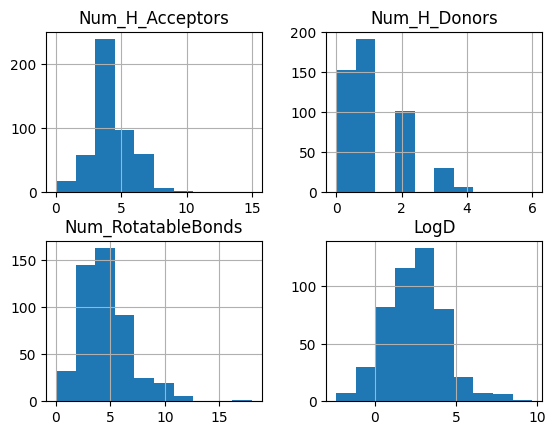

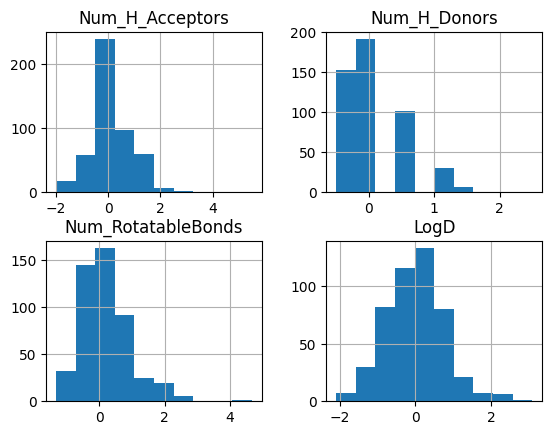

In [18]:
##test data

#Scaled_print(StandardScaler(),sub_test)
Scaled_print(RobustScaler(),sub_test)
#Scaled_print(MinMaxScaler(),sub_test)

### 정규화 수행 => 뒤의 Grid Search에서 진행

In [19]:
#sc_train = pd.DataFrame(RobustScaler().fit_transform(sub_train),columns=sub_train.columns)
#sc_test = pd.DataFrame(RobustScaler().fit_transform(sub_test),columns=sub_test.columns)

##8. 타겟 분포 확인 => 편향되어 있음

array([[<Axes: title={'center': 'MLM'}>, <Axes: title={'center': 'HLM'}>]],
      dtype=object)

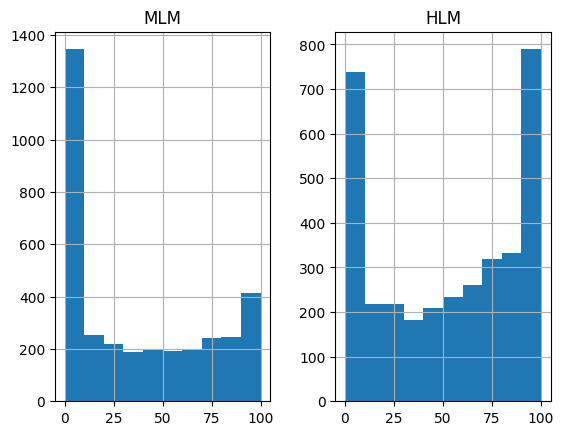

In [20]:
y.hist()

##9. 타겟 로그화 진행

타겟 편향을 해결하기 위한 방법

array([[<Axes: title={'center': 'MLM'}>, <Axes: title={'center': 'HLM'}>]],
      dtype=object)

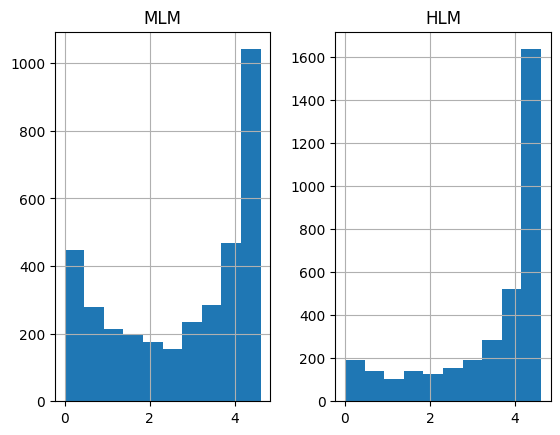

In [21]:
y['MLM']=np.log1p(y.MLM)
y['HLM']=np.log1p(y.HLM)

y.hist()

## 10. 모델 학습

### 필요한 라이브러리 import

In [22]:
##파이프라인 만들기 위한 라이브러리
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

## 피쳐 선택을 위한 라이브러리
from sklearn.feature_selection import f_regression, SelectKBest

##그리드 서치 라이브러리
from sklearn.model_selection import GridSearchCV

### Linear Regression
from sklearn.linear_model import LinearRegression

### Ridge model
from sklearn.linear_model import Ridge

### Rasso model
from sklearn.linear_model import Lasso


### Linear Regression


In [23]:
#파이프라인 구성
pipe_lr = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('selector',SelectKBest(score_func=f_regression)),
    ('scaler', RobustScaler()),
    ('reg', LinearRegression())
])

#조절할 파라미터
params_lr={
    'reg__fit_intercept':[True,False],
    'reg__positive':[True,False],
    'selector__k':[1,2,3,4,5,6,7]
}

grid_pipe_lr = GridSearchCV(pipe_lr,
                         param_grid=params_lr,
                         cv=10,scoring='neg_mean_squared_error',
                         verbose=1)

grid_pipe_lr.fit(train, y.MLM)
print(grid_pipe_lr.best_params_)
print(grid_pipe_lr.best_score_)

best_lr_mlm = grid_pipe_lr.best_estimator_

grid_pipe_lr.fit(train, y.HLM)
print(grid_pipe_lr.best_params_)
print(grid_pipe_lr.best_score_)

best_lr_hlm = grid_pipe_lr.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits
{'reg__fit_intercept': True, 'reg__positive': False, 'selector__k': 7}
-2.1783989863415982
Fitting 10 folds for each of 28 candidates, totalling 280 fits
{'reg__fit_intercept': True, 'reg__positive': False, 'selector__k': 7}
-1.5992909639148085


### Ridge

In [24]:
#파이프라인 구성
pipe_rg = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('selector',SelectKBest(score_func=f_regression)),
    ('scaler', RobustScaler()),
    ('reg',Ridge(random_state=42))
])

#조절할 파라미터
params_rg={
    'reg__fit_intercept':[True,False],
    'reg__positive':[True,False],
    'reg__alpha':[1.0,2.5,5,10],
    'reg__tol':[1e-6,1e-5,1e-4,1e-3],
    'reg__max_iter':[300,500,1000,1500],
    'selector__k':[1,2,3,4,5,6,7]
}

grid_pipe_rg = GridSearchCV(pipe_rg,
                         param_grid=params_rg,
                         cv=5,scoring='neg_mean_squared_error',
                         verbose=1)

grid_pipe_rg.fit(train, y.MLM)
print(grid_pipe_rg.best_params_)
print(grid_pipe_rg.best_score_)

best_rg_mlm = grid_pipe_rg.best_estimator_

grid_pipe_rg.fit(train, y.HLM)
print(grid_pipe_rg.best_params_)
print(grid_pipe_rg.best_score_)

best_rg_hlm = grid_pipe_rg.best_estimator_

Fitting 5 folds for each of 1792 candidates, totalling 8960 fits
{'reg__alpha': 10, 'reg__fit_intercept': True, 'reg__max_iter': 300, 'reg__positive': False, 'reg__tol': 1e-06, 'selector__k': 7}
-2.176867027947226
Fitting 5 folds for each of 1792 candidates, totalling 8960 fits
{'reg__alpha': 10, 'reg__fit_intercept': True, 'reg__max_iter': 300, 'reg__positive': False, 'reg__tol': 1e-06, 'selector__k': 7}
-1.5970431591516054


### Lasso

In [ ]:
#파이프라인 구성
pipe_ls = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('selector',SelectKBest(score_func=f_regression)),
    ('scaler', RobustScaler()),
    ('reg',Lasso(random_state=42))
])

#조절할 파라미터
params_ls={
    'reg__fit_intercept':[True,False],
    'reg__positive':[True,False],
    'reg__alpha':[1.0,2.5,5,10],
    'reg__tol':[1e-6,1e-5,1e-4,1e-3],
    'reg__max_iter':[300,500,1000,1500],
    'reg__warm_start':[True,False],
    'selector__k':[1,2,3,4,5,6,7]
}

grid_pipe_ls = GridSearchCV(pipe_ls,
                         param_grid=params_ls,
                         cv=5,scoring='neg_mean_squared_error',
                         verbose=1)

grid_pipe_ls.fit(train, y.MLM)
print(grid_pipe_ls.best_params_)
print(grid_pipe_ls.best_score_)

best_rs_mlm = grid_pipe_ls.best_estimator_

grid_pipe_ls.fit(train, y.HLM)
print(grid_pipe_ls.best_params_)
print(grid_pipe_ls.best_score_)

best_ls_hlm = grid_pipe_ls.best_estimator_


Fitting 5 folds for each of 3584 candidates, totalling 17920 fits
{'reg__alpha': 1.0, 'reg__fit_intercept': True, 'reg__max_iter': 300, 'reg__positive': True, 'reg__tol': 1e-06, 'reg__warm_start': True, 'selector__k': 1}
-2.562498274701302
Fitting 5 folds for each of 3584 candidates, totalling 17920 fits


### SGDRegressor

In [ ]:
from sklearn.linear_model import SGDRegressor


#파이프라인 구성
pipe = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('selector',SelectKBest(score_func=f_regression)),
    ('scaler', StandardScaler()),
    ('reg',SGDRegressor(loss='squared_error',random_state=42,early_stopping=True))
])

#조절할 파라미터
params={
    'reg__penalty':['l1','l2'],
    'reg__fit_intercept':[True,False],
    'reg__alpha':[0.0001,0.001,0.005],
    'reg__tol':[1e-6,1e-5,1e-4,1e-3],
    'reg__learning_rate':['constant','optimal','adaptive'],
    'reg__validation_fraction':[0.1,0.2,0.3],
    'reg__max_iter':[300,500,1000,1500],
    'reg__warm_start':[True,False],
    'selector__k':[1,2,3,4,5,6,7]
}


grid_pipe = GridSearchCV(pipe,
                         param_grid=params,
                         cv=5,scoring='neg_mean_squared_error',
                         verbose=1)

grid_pipe.fit(train, y.MLM)
print(grid_pipe.best_params_)
print(grid_pipe.best_score_)

best_rs_mlm = grid_pipe.best_estimator_

grid_pipe.fit(train, y.HLM)
print(grid_pipe.best_params_)
print(grid_pipe.best_score_)

best_rs_hlm = grid_pipe.best_estimator_

## 11. 모델 선택 및 예측

그리드 서치 통해서 성능이 좋았던 모델로 다시 예측

### 평가지표 계산 함수

In [ ]:
### 함수 만들기
from sklearn.metrics import mean_absolute_error,mean_squared_error

#rmsle 함수
def rmsle(y,pred):
    #log 함수는 Nan 처리가 어려워서 log1p 함수 이용
    log_y=np.log1p(y)
    log_pred=np.log1p(pred)
    se=(log_y-log_pred)**2
    rmsle=np.sqrt(np.mean(se))
    return rmsle

#rmse 함수
def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate(y,pred):
    rmsle_val=rmsle(y,pred)
    rmse_val=rmse(y,pred)
    mae_val=mean_absolute_error(y,pred)
    print('rmsle:{0},rmse:{1},mae:{2}'.format(rmsle_val,rmse_val,mae_val))


### 모델 훈련 후 평가지표 확인 함수

타겟 로그화 진행했으므로 최종 평가지표에서는 expm1 이용해서 계산 필요

In [ ]:
def model_predict(model, X_train, X_test, y_train, y_test,expm1=False):
    model.fit(X_train, y_train)
    pred=model.predict(X_test)
    if expm1:
        y_test=np.expm1(y_test)
        pred=np.expm1(pred)
    print(model.__class__.__name__)
    evaluate(y_test,pred)

### 최종 선택된 모델로 예측 결과 확인

In [ ]:
grid_pipe_.predict(test)
grid_pipe_.predict(test)

submission['MLM']=grid_pipe_mlm.predict(test)
submission['HLM']=grid_pipe_hlm.predict(test)

print(submission)
submission.to_csv('../data/sample_submission_0905_3.csv')

In [ ]:
submission['MLM']=lr_mlm.predict(test)
submission['HLM']=lr_hlm.predict(test)

print(submission)
submission.to_csv('../data/sample_submission.csv')